In [2]:
import numpy as np
import os
import pandas as pd
import xarray as xr

import matplotlib as mpl
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
# from matplotlib.colors import DivergingNorm
# import matplotlib.patches as patches
%matplotlib inline
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import seaborn as sns; sns.set(color_codes=False)
import cmocean
# from windrose import WindroseAxes
import warnings

import cftime
import datetime


plt.rcParams['xtick.bottom'] = True # keep my tick marks
plt.rcParams['ytick.left'] = True
plt.rcParams['font.size'] = 18
# plt.rcParams["font.family"] = "Arial"
# plt.rcParams['figure.figsize'] = 12,8
# mpl.rcParams['figure.dpi'] = 300 # activate for presentation quality

# from sklearn.metrics.pairwise import haversine_distances

## this is a dummy grid that has the right conventions
grid = xr.open_dataset(
    '/glade/work/vcooper/grid_ref/sithick_SImon_CESM2_piControl_r1i1p1f1_gn_110001-120012.nc')
latmin = 72
latmax = 79
lonmin = 195
lonmax = 230
beau_mask = (
    (grid.coords['lon'] > lonmin) 
    & (grid.coords['lon'] < lonmax)
    & (grid.coords['lat'] > latmin)
    & (grid.coords['lat'] < latmax)
)

## circle boundary for plotting
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpl.path.Path(verts * radius + center)

## keep cice 2018 output because of detailed grid
mdir_adj = '/glade/u/home/vcooper/work/BGEP_vtc/adjfiles/' # location of adjusted files, changed dims to lat and lon
cice18 = xr.open_dataset(mdir_adj + 'cicefsdww3i.cice.h1.0086.nc') # 2018 rerun
cice18.TLAT[:] = grid.lat # hack to fix polar stereo
cice18.TLON[:] = grid.lon
tarea = cice18.tarea.rename(
    {'TLON':'longitude','TLAT':'latitude'}).reset_coords(names=['ULON','ULAT'],drop=True)

/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/xarray/conventions.py:500: SerializationWarning: variable 'sithick' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,


In [3]:
import copy
import dask
from glob import glob
latslice=slice(300,384)

In [4]:
%%time
###### Coupled Model Update May 2021 #####
## loading in and concat data 
ww2012 = xr.open_dataset('/glade/scratch/vcooper/waveice_analysis/cesm23iws1tsks.ww3.hi.2012.nc')
# ww2013 = xr.open_dataset('/glade/scratch/vcooper/waveice_analysis/cesm23iws1tsks.ww3.hi.2013.nc')
# ww2014 = xr.open_dataset('/glade/scratch/vcooper/waveice_analysis/cesm23iws1tsks.ww3.hi.2014.nc')
# ww2015 = xr.open_dataset('/glade/scratch/vcooper/waveice_analysis/cesm23iws1tsks.ww3.hi.2015.nc')
# ww2016 = xr.open_dataset('/glade/scratch/vcooper/waveice_analysis/cesm23iws1tsks.ww3.hi.2016.nc')
# ww2017 = xr.open_dataset('/glade/scratch/vcooper/waveice_analysis/cesm23iws1tsks.ww3.hi.2017.nc')
# ww2018 = xr.open_dataset('/glade/scratch/vcooper/waveice_analysis/cesm23iws1tsks.ww3.hi.2018.nc')
# ww2019 = xr.open_dataset('/glade/scratch/vcooper/waveice_analysis/cesm23iws1tsks.ww3.hi.2019.nc')

ww_dict = {'ww2012' : ww2012}
#            'ww2013' : ww2013,
#            'ww2014' : ww2014,
#            'ww2015' : ww2015,
#            'ww2016' : ww2016,
#            'ww2017' : ww2017,
#            'ww2018' : ww2018,
#            'ww2019' : ww2019}

temp_f = xr.open_dataset('./ww1719ef_beau_cat.nc')

for key,val in ww_dict.items():
    print(key)
#     val = val.rename({'UAX': 'uwnd',
#                 'UAY': 'vwnd',
#                 'ICE': 'ice',
#                 'HS':  'hs',
#                 'T02': 't02',
#                 'T0M1':'t0m1',
#                 'T01': 't01',
#                 'FP0': 'fp',
#                 'THM': 'dir',
#                 'EF':  'ef',
#                 'FREQ':'f',
#                 'NX':  'ni',
#                 'NY':  'nj'})
    
    val['latitude'] = (['nj','ni'],grid.lat.values)
    val['longitude'] = (['nj','ni'],grid.lon.values)
    val = val.set_coords(['time','latitude','longitude'])
#     val['f'] = temp_f.f
    val['FREQ'] = temp_f.f.values
#     val = val.sel(nj=latslice)
#     val['tarea'] = (['nj','ni'],cice18.tarea.sel(nj=latslice).values)
    val['tarea'] = (['nj','ni'],cice18.tarea.values)
    val.coords['mask'] = (('nj','ni'), beau_mask.values)
#     val = val.where(val.mask > 0, drop=True) ## only keep if dropping to beau
    ww_dict[key] = val

##########################################

ww2012
CPU times: user 19.9 ms, sys: 3.19 ms, total: 23.1 ms
Wall time: 80.3 ms


In [5]:
casename = 'cesm23iws1tsks_linearice1'
ctrlname = 'cesm23iws1tsks_bittest1'
monsel = 7

rundir = '/glade/scratch/vcooper/' + casename + '/run/'
rundir_cp = copy.copy(rundir)
flist = casename + '.ww3.hi.2012-*.nc'
dfiles = sorted(glob(rundir + flist))
dfiles_np = np.array(dfiles)
dfiles_ind = np.where(xr.where(ww2012.time.dt.month==monsel,1,0))[0]
dfiles = dfiles_np[dfiles_ind][0:-1:100]
# print(len(dfiles), len(ww2012.time[0:len(dfiles)]))
print(len(dfiles), len(ww2012.time[dfiles_ind][0:-1:100]))

tempdates = ww2012.time[dfiles_ind][0:-1:100].dt.strftime('%Y-%m-%d').values

8 8


In [6]:
%%time
## SET THIS
casename = 'cesm23iws1tsks_linearice1'
ctrlname = 'cesm23iws1tsks_bittest1'
monsel = 7


###### WW3 ########
def preprocess(ds):
#     ds = ds[['HS','ICE']]
    ds = ds.expand_dims(time = [datetime.datetime.now()]) ## dummy time
    return ds

## experiment ww3
rundir = '/glade/scratch/vcooper/' + casename + '/run/'
rundir_cp = copy.copy(rundir)
flist = casename + '.ww3.hi.2012-*.nc'
dfiles = sorted(glob(rundir + flist))
dfiles_n = len(dfiles)
dfiles_np = np.array(dfiles)
dfiles_ind = np.where(xr.where(ww2012.time.dt.month==monsel,1,0))[0]
dfiles = dfiles_np[dfiles_ind][0:-1:100]
# print(len(dfiles), len(ww2012.time[0:len(dfiles)]))
print(len(dfiles), len(ww2012.time[dfiles_ind][0:-1:100]))

mfds_temp = xr.open_mfdataset(dfiles,
                              combine='by_coords',
                              coords='minimal',
                              concat_dim='time',
                              compat='override',
                              preprocess=preprocess,
                              parallel=False)
# mfds_temp['time'] = ww2012.time[0:len(dfiles)]
mfds_temp['time'] = ww2012.time[dfiles_ind][0:-1:100]

exp_ww = mfds_temp.load()

## control wavewatch, limited to length of experiment
casename_cp = copy.copy(casename)
casename = ctrlname
rundir = '/glade/scratch/vcooper/' + casename + '/run/'
flist = casename + '.ww3.hi.2012-*.nc'
dfiles = sorted(glob(rundir + flist))[:dfiles_n]
dfiles_np = np.array(dfiles)
dfiles_ind = np.where(xr.where(ww2012.time.dt.month==monsel,1,0))[0]
dfiles = dfiles_np[dfiles_ind][0:-1:100]
# print(len(dfiles), len(ww2012.time[0:len(dfiles)]))
print(len(dfiles), len(ww2012.time[dfiles_ind][0:-1:100]))

mfds_temp = xr.open_mfdataset(dfiles,
                              combine='by_coords',
                              coords='minimal',
                              concat_dim='time',
                              compat='override',
                              preprocess=preprocess,
                              parallel=False)
# mfds_temp['time'] = ww2012.time[0:len(dfiles)]
mfds_temp['time'] = ww2012.time[dfiles_ind][0:-1:100]

ctrl_ww = mfds_temp.load()
casename = casename_cp
rundir = rundir_cp

print('done loading ww3')
###### CICE ########

## cice experiment
def preprocess_cice(ds):
    ds = ds[['tarea', 'fsdrad_d', 'hi_d', 'aice_d']].drop(['ULAT','ULON'])
    return ds

flist = casename + '.cice.h1.2012-*.nc'
dfiles = sorted(glob(rundir + flist))
dfiles_n_cice = len(dfiles)

dfiles_ind_cice = np.array([])
dfiles_np = np.array(dfiles)

for j,tempd in enumerate(tempdates):
    for i,ff in enumerate(dfiles_np):
        if str(tempd) in ff:
            dfiles_ind_cice = np.append(dfiles_ind_cice,ff)
            break


mfds_temp = xr.open_mfdataset(dfiles_ind_cice,
                              combine='by_coords',
                              coords='minimal',
                              concat_dim='time',
                              compat='override',
                              preprocess=preprocess_cice)
exp_cice = mfds_temp.load()

## cice control
flist = ctrlname + '.cice.h1.2012-*.nc'
rundir = '/glade/scratch/vcooper/' + ctrlname + '/run/'
dfiles = sorted(glob(rundir + flist))[:dfiles_n_cice]

dfiles_ind_cice = np.array([])
dfiles_np = np.array(dfiles)

for j,tempd in enumerate(tempdates):
    for i,ff in enumerate(dfiles_np):
        if str(tempd) in ff:
            dfiles_ind_cice = np.append(dfiles_ind_cice,ff)
            break

mfds_temp = xr.open_mfdataset(dfiles_ind_cice,
                              combine='by_coords',
                              coords='minimal',
                              concat_dim='time',
                              compat='override',
                              preprocess=preprocess_cice)
ctrl_cice = mfds_temp.load()


## add coordinates
exp_ww = exp_ww.assign_coords({'FREQ':temp_f.f.values})
exp_ww['TLON'] = (exp_ww.HS[0].dims, grid.lon.values)
exp_ww['TLAT'] = (exp_ww.HS[0].dims, grid.lat.values)
ctrl_ww = ctrl_ww.assign_coords({'FREQ':temp_f.f.values})
ctrl_ww['TLON'] = (exp_ww.HS[0].dims, grid.lon.values)
ctrl_ww['TLAT'] = (exp_ww.HS[0].dims, grid.lat.values)

exp_cice['TLON'] = (exp_cice.aice_d[0].dims, grid.lon.values)
exp_cice['TLAT'] = (exp_cice.aice_d[0].dims, grid.lat.values)
ctrl_cice['TLON'] = (exp_cice.aice_d[0].dims, grid.lon.values)
ctrl_cice['TLAT'] = (exp_cice.aice_d[0].dims, grid.lat.values)

8 8
8 8
done loading ww3
CPU times: user 1.34 s, sys: 316 ms, total: 1.66 s
Wall time: 4.05 s


## WW3 Comparisons

/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:67: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


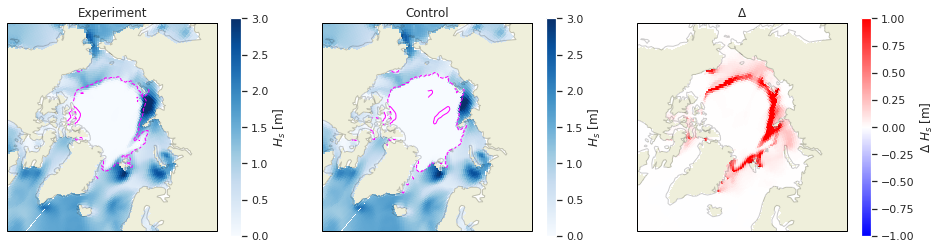

In [7]:
lowlat = 60

exp_plot = exp_ww.isel(time=-1)
ctrl_plot = ctrl_ww.isel(time=-1)
diff_plot = exp_plot - ctrl_plot

## HS ##
fig,ax = plt.subplots(1,3,figsize=(16,4),subplot_kw={'projection': ccrs.NorthPolarStereo()})
## exp ##
aind = 0
plt.sca(ax[aind])
ax[aind].coastlines(alpha=0.2,lw=1)
ax[aind].set_extent([-180,180,lowlat,90], ccrs.PlateCarree())
ax[aind].add_feature(cfeature.LAND)
plt.title('Experiment')

plt.pcolormesh(exp_plot.TLON,exp_plot.TLAT,exp_plot.HS,#.where(exp_plot.TLON < 180),
               vmin=0.00,vmax=3,cmap='Blues',
               transform=ccrs.PlateCarree())
plt.colorbar(label='$H_s$ [m]')

plt.contour(exp_plot.TLON,exp_plot.TLAT,
            exp_plot.ICE.where(exp_plot.TLON < 180),
            levels=[0.01,0.8],colors='magenta',linestyles=['--','-'],linewidths=1,
            transform=ccrs.PlateCarree())
plt.contour(exp_plot.TLON,exp_plot.TLAT,
            exp_plot.ICE.where(exp_plot.TLON > 180),
            levels=[0.01,0.9],colors='magenta',linestyles=['--','-'],linewidths=1,
            transform=ccrs.PlateCarree())


## control ##
aind = 1
plt.sca(ax[aind])
ax[aind].coastlines(alpha=0.2,lw=1)
ax[aind].set_extent([-180,180,lowlat,90], ccrs.PlateCarree())
ax[aind].add_feature(cfeature.LAND)
plt.title('Control')

plt.pcolormesh(exp_plot.TLON,exp_plot.TLAT,ctrl_plot.HS,#.where(exp_plot.TLON < 180),
               vmin=0.00,vmax=3,cmap='Blues',
               transform=ccrs.PlateCarree())
plt.colorbar(label='$H_s$ [m]')

plt.contour(exp_plot.TLON,exp_plot.TLAT,
            ctrl_plot.ICE.where(ctrl_plot.TLON < 180),
            levels=[0.01,0.8],colors='magenta',linestyles=['--','-'],linewidths=1,
            transform=ccrs.PlateCarree())
plt.contour(exp_plot.TLON,exp_plot.TLAT,
            ctrl_plot.ICE.where(ctrl_plot.TLON > 180),
            levels=[0.01,0.9],colors='magenta',linestyles=['--','-'],linewidths=1,
            transform=ccrs.PlateCarree())

## diff ##
aind = 2
plt.sca(ax[aind])
ax[aind].coastlines(alpha=0.2,lw=1)
ax[aind].set_extent([-180,180,lowlat,90], ccrs.PlateCarree())
ax[aind].add_feature(cfeature.LAND)
plt.title('$\Delta$')

plt.pcolormesh(exp_plot.TLON,exp_plot.TLAT,diff_plot.HS,#.where(exp_plot.TLON < 180),
               vmin=-1,vmax=1,cmap='bwr',
               transform=ccrs.PlateCarree())
plt.colorbar(label='$\Delta$ $H_s$ [m]')

plt.tight_layout()
plt.show()

/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:61: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


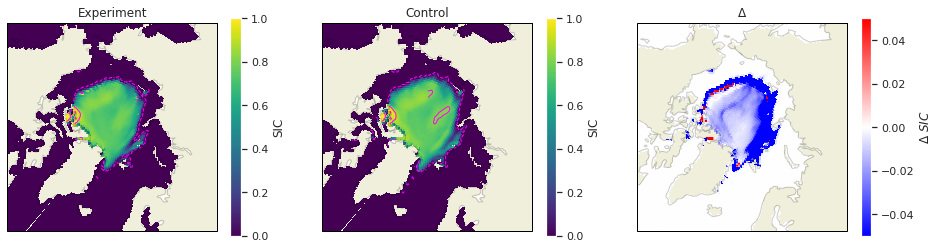

In [8]:
## ICE ##
fig,ax = plt.subplots(1,3,figsize=(16,4),subplot_kw={'projection': ccrs.NorthPolarStereo()})
## exp ##
aind = 0
plt.sca(ax[aind])
ax[aind].coastlines(alpha=0.2,lw=1)
ax[aind].set_extent([-180,180,lowlat,90], ccrs.PlateCarree())
ax[aind].add_feature(cfeature.LAND)
plt.title('Experiment')

plt.pcolormesh(exp_plot.TLON,exp_plot.TLAT,exp_plot.ICE,#.where(exp_plot.TLON < 180),
               vmin=0.00,vmax=1,cmap='viridis',
               transform=ccrs.PlateCarree())
plt.colorbar(label='SIC')

plt.contour(exp_plot.TLON,exp_plot.TLAT,
            exp_plot.ICE.where(exp_plot.TLON < 180),
            levels=[0.01,0.8],colors='magenta',linestyles=['--','-'],linewidths=1,
            transform=ccrs.PlateCarree())
plt.contour(exp_plot.TLON,exp_plot.TLAT,
            exp_plot.ICE.where(exp_plot.TLON > 180),
            levels=[0.01,0.9],colors='magenta',linestyles=['--','-'],linewidths=1,
            transform=ccrs.PlateCarree())


## control ##
aind = 1
plt.sca(ax[aind])
ax[aind].coastlines(alpha=0.2,lw=1)
ax[aind].set_extent([-180,180,lowlat,90], ccrs.PlateCarree())
ax[aind].add_feature(cfeature.LAND)
plt.title('Control')

plt.pcolormesh(exp_plot.TLON,exp_plot.TLAT,ctrl_plot.ICE,#.where(exp_plot.TLON < 180),
               vmin=0.00,vmax=1,cmap='viridis',
               transform=ccrs.PlateCarree())
plt.colorbar(label='SIC')

plt.contour(exp_plot.TLON,exp_plot.TLAT,
            ctrl_plot.ICE.where(ctrl_plot.TLON < 180),
            levels=[0.01,0.8],colors='magenta',linestyles=['--','-'],linewidths=1,
            transform=ccrs.PlateCarree())
plt.contour(exp_plot.TLON,exp_plot.TLAT,
            ctrl_plot.ICE.where(ctrl_plot.TLON > 180),
            levels=[0.01,0.9],colors='magenta',linestyles=['--','-'],linewidths=1,
            transform=ccrs.PlateCarree())

## diff ##
aind = 2
plt.sca(ax[aind])
ax[aind].coastlines(alpha=0.2,lw=1)
ax[aind].set_extent([-180,180,lowlat,90], ccrs.PlateCarree())
ax[aind].add_feature(cfeature.LAND)
plt.title('$\Delta$')

plt.pcolormesh(exp_plot.TLON,exp_plot.TLAT,diff_plot.ICE,#.where(exp_plot.TLON < 180),
               vmin=-0.05,vmax=0.05,cmap='bwr',
               transform=ccrs.PlateCarree())
plt.colorbar(label='$\Delta$ $SIC$')

plt.tight_layout()
plt.show()

### CICE Comparisons

/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:74: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


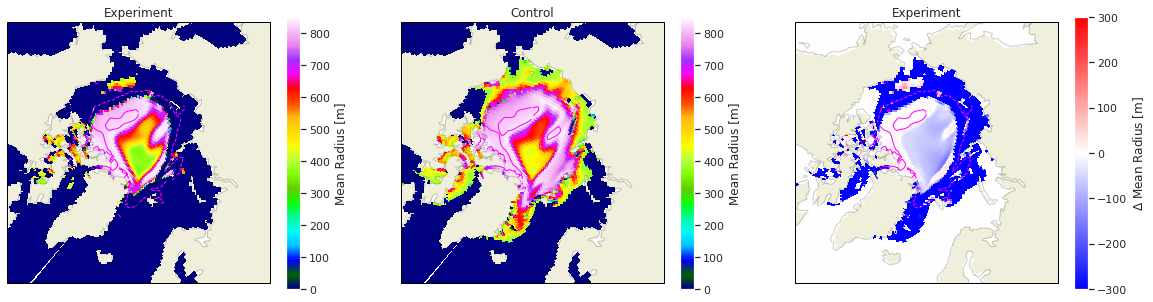

In [9]:
exp_plot = exp_cice.isel(time=-1)
ctrl_plot = ctrl_cice.isel(time=-1)
diff_plot = exp_plot - ctrl_plot

## HS ##
fig,ax = plt.subplots(1,3,figsize=(20,5),subplot_kw={'projection': ccrs.NorthPolarStereo()})
## exp ##
aind = 0
plt.sca(ax[aind])
ax[aind].coastlines(alpha=0.2,lw=1)
ax[aind].set_extent([-180,180,lowlat,90], ccrs.PlateCarree())
ax[aind].add_feature(cfeature.LAND)
plt.title('Experiment')

plt.pcolormesh(exp_ww.TLON,exp_ww.TLAT,exp_plot.fsdrad_d,#.where(exp_plot.TLON < 180),
               vmin=0.00,vmax=850,cmap='gist_ncar',
               transform=ccrs.PlateCarree())
plt.colorbar(label='Mean Radius [m]')

plt.contour(exp_ww.TLON.values,exp_ww.TLAT.values,
            exp_plot.aice_d.where(exp_ww.TLON.values < 180),
            levels=[0.01,0.8],colors='magenta',linestyles=['--','-'],linewidths=1,
            transform=ccrs.PlateCarree())
plt.contour(exp_ww.TLON.values,exp_ww.TLAT.values,
            exp_plot.aice_d.where(exp_ww.TLON.values > 180),
            levels=[0.01,0.8],colors='magenta',linestyles=['--','-'],linewidths=1,
            transform=ccrs.PlateCarree())


## control ##
aind = 1
plt.sca(ax[aind])
ax[aind].coastlines(alpha=0.2,lw=1)
ax[aind].set_extent([-180,180,lowlat,90], ccrs.PlateCarree())
ax[aind].add_feature(cfeature.LAND)
plt.title('Control')

plt.pcolormesh(exp_ww.TLON,exp_ww.TLAT,ctrl_plot.fsdrad_d,#.where(exp_plot.TLON < 180),
               vmin=0.00,vmax=850,cmap='gist_ncar',
               transform=ccrs.PlateCarree())
plt.colorbar(label='Mean Radius [m]')

plt.contour(exp_ww.TLON.values,exp_ww.TLAT.values,
            ctrl_plot.aice_d.where(exp_ww.TLON.values < 180),
            levels=[0.01,0.8],colors='magenta',linestyles=['--','-'],linewidths=1,
            transform=ccrs.PlateCarree())
plt.contour(exp_ww.TLON.values,exp_ww.TLAT.values,
            ctrl_plot.aice_d.where(exp_ww.TLON.values > 180),
            levels=[0.01,0.8],colors='magenta',linestyles=['--','-'],linewidths=1,
            transform=ccrs.PlateCarree())

# ## diff ##
aind = 2
plt.sca(ax[aind])
ax[aind].coastlines(alpha=0.2,lw=1)
ax[aind].set_extent([-180,180,lowlat,90], ccrs.PlateCarree())
ax[aind].add_feature(cfeature.LAND)
plt.title('Experiment')

plt.pcolormesh(exp_ww.TLON,exp_ww.TLAT,diff_plot.fsdrad_d,#.where(exp_plot.TLON < 180),
               vmin=-300,vmax=300,cmap='bwr',
               transform=ccrs.PlateCarree())
plt.colorbar(label='$\Delta$ Mean Radius [m]')

plt.contour(exp_ww.TLON.values,exp_ww.TLAT.values,
            exp_plot.aice_d.where(exp_ww.TLON.values < 180),
            levels=[0.01,0.8],colors='magenta',linestyles=['--','-'],linewidths=1,
            transform=ccrs.PlateCarree())
plt.contour(exp_ww.TLON.values,exp_ww.TLAT.values,
            exp_plot.aice_d.where(exp_ww.TLON.values > 180),
            levels=[0.01,0.8],colors='magenta',linestyles=['--','-'],linewidths=1,
            transform=ccrs.PlateCarree())

plt.tight_layout()
plt.show()

/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:74: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


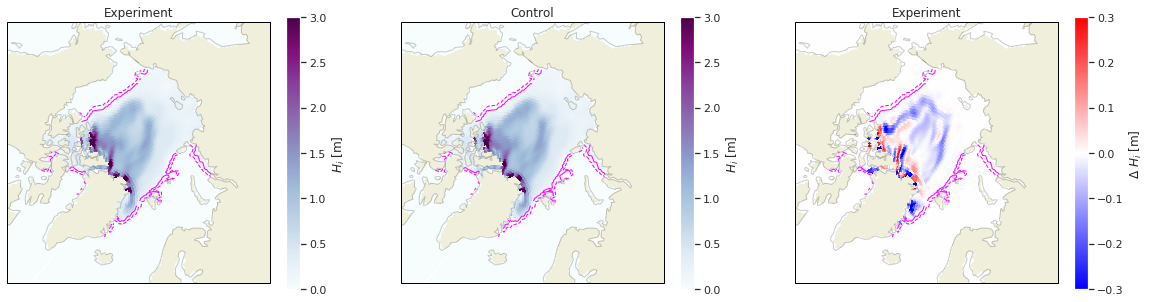

In [100]:
exp_plot = exp_cice.isel(time=-1)
ctrl_plot = ctrl_cice.isel(time=-1)
diff_plot = exp_plot - ctrl_plot

## HS ##
fig,ax = plt.subplots(1,3,figsize=(20,5),subplot_kw={'projection': ccrs.NorthPolarStereo()})
## exp ##
aind = 0
plt.sca(ax[aind])
ax[aind].coastlines(alpha=0.2,lw=1)
ax[aind].set_extent([-180,180,lowlat,90], ccrs.PlateCarree())
ax[aind].add_feature(cfeature.LAND)
plt.title('Experiment')

plt.pcolormesh(exp_ww.TLON,exp_ww.TLAT,exp_plot.hi_d,#.where(exp_plot.TLON < 180),
               vmin=0.00,vmax=3,cmap='BuPu',
               transform=ccrs.PlateCarree())
plt.colorbar(label='$H_i$ [m]')

plt.contour(exp_ww.TLON.values,exp_ww.TLAT.values,
            exp_plot.aice_d.where(exp_ww.TLON.values < 180),
            levels=[0.01,0.8],colors='magenta',linestyles=['--','-'],linewidths=1,
            transform=ccrs.PlateCarree())
plt.contour(exp_ww.TLON.values,exp_ww.TLAT.values,
            exp_plot.aice_d.where(exp_ww.TLON.values > 180),
            levels=[0.01,0.8],colors='magenta',linestyles=['--','-'],linewidths=1,
            transform=ccrs.PlateCarree())


## control ##
aind = 1
plt.sca(ax[aind])
ax[aind].coastlines(alpha=0.2,lw=1)
ax[aind].set_extent([-180,180,lowlat,90], ccrs.PlateCarree())
ax[aind].add_feature(cfeature.LAND)
plt.title('Control')

plt.pcolormesh(exp_ww.TLON,exp_ww.TLAT,ctrl_plot.hi_d,#.where(exp_plot.TLON < 180),
               vmin=0.00,vmax=3,cmap='BuPu',
               transform=ccrs.PlateCarree())
plt.colorbar(label='$H_i$ [m]')

plt.contour(exp_ww.TLON.values,exp_ww.TLAT.values,
            ctrl_plot.aice_d.where(exp_ww.TLON.values < 180),
            levels=[0.01,0.8],colors='magenta',linestyles=['--','-'],linewidths=1,
            transform=ccrs.PlateCarree())
plt.contour(exp_ww.TLON.values,exp_ww.TLAT.values,
            ctrl_plot.aice_d.where(exp_ww.TLON.values > 180),
            levels=[0.01,0.8],colors='magenta',linestyles=['--','-'],linewidths=1,
            transform=ccrs.PlateCarree())

# ## diff ##
aind = 2
plt.sca(ax[aind])
ax[aind].coastlines(alpha=0.2,lw=1)
ax[aind].set_extent([-180,180,lowlat,90], ccrs.PlateCarree())
ax[aind].add_feature(cfeature.LAND)
plt.title('Experiment')

plt.pcolormesh(exp_ww.TLON,exp_ww.TLAT,diff_plot.hi_d,#.where(exp_plot.TLON < 180),
               vmin=-0.3,vmax=0.3,cmap='bwr',
               transform=ccrs.PlateCarree())
plt.colorbar(label='$\Delta$ $H_i$ [m]')

plt.contour(exp_ww.TLON.values,exp_ww.TLAT.values,
            exp_plot.aice_d.where(exp_ww.TLON.values < 180),
            levels=[0.01,0.8],colors='magenta',linestyles=['--','-'],linewidths=1,
            transform=ccrs.PlateCarree())
plt.contour(exp_ww.TLON.values,exp_ww.TLAT.values,
            exp_plot.aice_d.where(exp_ww.TLON.values > 180),
            levels=[0.01,0.8],colors='magenta',linestyles=['--','-'],linewidths=1,
            transform=ccrs.PlateCarree())

plt.tight_layout()
plt.show()

In [71]:
%%time
## get all spectra where H_s is different by at least 0.1 and SIC > 0.01 in both
masksel = xr.where((exp_ww.TLAT > 0) & 
                   (exp_ww.ICE > 0.15) & (ctrl_ww.ICE > 0.15) &
                   (exp_ww.HS  > 0.3) &
                   ((exp_ww.HS - ctrl_ww.HS) > 0.1),True,False)

stacked = exp_ww.EF.where(masksel,drop=True).stack(cell=('time','NX','NY'))
stacked_c = ctrl_ww.EF.where(masksel,drop=True).stack(cell=('time','NX','NY'))

stacked = stacked.where(np.any(~np.isnan(stacked),axis=0),drop=True)
stacked_c = stacked_c.where(np.any(~np.isnan(stacked),axis=0),drop=True)

CPU times: user 294 ms, sys: 45.3 ms, total: 339 ms
Wall time: 338 ms


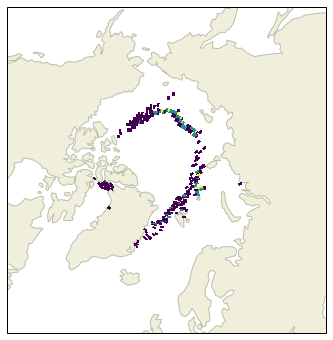

In [72]:
## where are the diffs
minlat = 55
fig = plt.subplots(figsize=(8,6))
npolarplot(55)

plt.pcolormesh(exp_ww.TLON,exp_ww.TLAT,masksel.sum(dim='time').where(masksel.sum(dim='time') > 0),
               cmap='viridis',
               transform=ccrs.PlateCarree())
plt.show()

In [70]:
# with sns.axes_style('ticks'):
#     plt.grid(True,which='both',alpha=0.5)
#     print(control_ww.sel(NY=latslice).HS[temp['NY'],temp['NX']],
#           wind_exp_ww.sel(NY=latslice).HS[temp['NY'],temp['NX']])
#     print(control_ww.sel(NY=latslice).ICE[temp['NY'],temp['NX']],
#           wind_exp_ww.sel(NY=latslice).ICE[temp['NY'],temp['NX']])
#     print(cwind[temp['NY'],temp['NX']])
#     control_ww.sel(NY=latslice).EF[:,temp['NY'],temp['NX']].plot(c='royalblue',alpha=0.6,lw=3,label='VTC control')
#     wind_exp_ww.sel(NY=latslice).EF[:,temp['NY'],temp['NX']].plot(c='r',ls='--',label='Wind source experiment')
#     plt.loglog()
#     # plt.xlim(0.06,0.5)
#     # plt.ylim(.01,10)
#     plt.xlim(10**(-1.24),10**(-0.3))
#     plt.ylim(10**(-4),5*10**(1))
# #     plt.title('Maximum H$_s$ on 2012-08-10: '+ str(np.round(wind_exp_ww_sub.HS[55,212].values,2)) + ' [m]')
#     plt.legend()
#     plt.show()
    
#     plt.grid(True,which='both',alpha=0.5)
#     control_ww.sel(NY=latslice).EF[:,temp['NY'],temp['NX']].plot(c='royalblue',alpha=0.6,lw=3,label='VTC control')
#     wind_exp_ww.sel(NY=latslice).EF[:,temp['NY'],temp['NX']].plot(c='r',ls='--',label='Wind source experiment')
#     plt.loglog()
#     # plt.xlim(0.06,0.5)
#     # plt.ylim(.01,10)
# #     plt.xlim(10**(-1.24),10**(-0.3))
# #     plt.ylim(10**(-4),5*10**(1))
#     plt.title('Same data but without limiting axes')
#     plt.legend()
#     plt.show()


CPU times: user 6.37 s, sys: 5.42 s, total: 11.8 s
Wall time: 27.7 s


In [111]:
np.random.seed(51)
rind = np.random.choice(len(stacked.cell),3,replace=True)

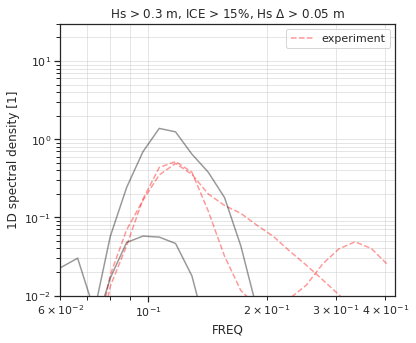

In [112]:
with sns.axes_style('ticks'):    
    fig = plt.subplots(1,1,figsize=(6,5),sharey=True,sharex=True)
    plt.subplot(111)
    stacked[:,rind].plot.line(x='FREQ',add_legend=False,alpha=0.4,ls='--',c='r')
    stacked_c[:,rind].plot.line(x='FREQ',add_legend=False,alpha=0.4,c='k')
    plt.ylim(10**-2,30)
    plt.xlim(0.06,)
    plt.legend(['experiment'])
    plt.loglog()
    plt.title('Hs > 0.3 m, ICE > 15%, Hs $\Delta$ > 0.05 m')
    plt.grid(True,which='both',alpha=0.5)
    plt.show()

## Check difference solely due to FSD floe frac randomness

In [1]:
newrun_all = xr.open_dataset(
    '/glade/scratch/vcooper/cesm23iws1tsks_bittest1/run/cesm23iws1tsks_bittest1.cice.h1.2013-12-31.nc')

newrun = xr.open_dataset(
    '/glade/scratch/vcooper/cesm23iws1tsks_bittest1/run/cesm23iws1tsks_bittest1.cice.h1.2013-12-31.nc')
newrun['TLON'] = (grid.lon.dims, grid.lon.values)
newrun['TLAT'] = (grid.lat.dims, grid.lat.values)
newrun = newrun.sel(nj=slice(280,384)).squeeze()
newrun

NameError: name 'xr' is not defined

In [8]:
# !cp /glade/scratch/bitz/cesm23iws1tsks/run/daily/cesm23iws1tsks.cice_nh.h1.2013-12.nc.gz /glade/scratch/vcooper/cesm23iws1tsks_bittest1/run/refrun/

In [9]:
# !gzip -d /glade/scratch/vcooper/cesm23iws1tsks_bittest1/run/refrun/cesm23iws1tsks.cice_nh.h1.2013-12.nc.gz

In [42]:
oldrun = xr.open_dataset(
    '/glade/scratch/vcooper/cesm23iws1tsks_bittest1/run/refrun/cesm23iws1tsks.cice_nh.h1.2013-12.nc')

In [43]:
oldrun_day = oldrun.sel(time='2013-12-31').squeeze()

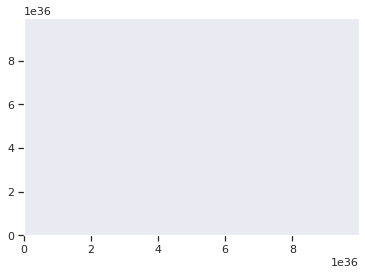

In [44]:
plt.pcolormesh(newrun.TLON, newrun.TLAT,
               oldrun_day.aice_d - newrun.aice_d,
               cmap='bwr')

In [83]:
temp1 = oldrun_day.tarea.where(oldrun_day.aice_d > 0.15).sum().values
temp2 = newrun.tarea.where(newrun.aice_d > 0.15).sum().values

(temp1-temp2)/temp1



-0.0011153176

In [91]:
temp1 / (1000**2) - 1.26407283893302474E+07

-12510.566098246723

In [103]:
tempsh = newrun_all.tarea.where((newrun_all.aice_d > 0.15) & (newrun_all.TLAT < 0)).sum().values / (1000**2)

In [85]:
newrun_all.tarea.where(newrun_all.aice_d > 0.15).sum().values

array(1.9060104e+13, dtype=float32)

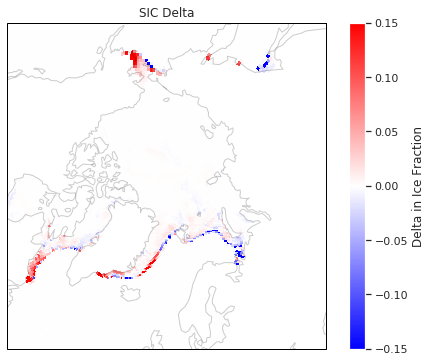

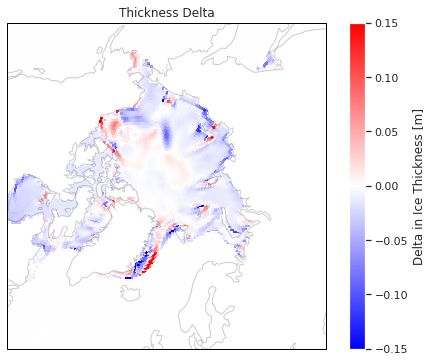

In [76]:
proj = ccrs.NorthPolarStereo()

fig = plt.subplots(figsize=(8,6))
ax = plt.subplot(projection=proj)
ax.set_extent([0.005, 360, 55, 90], crs=ccrs.PlateCarree())
ax.coastlines(alpha=0.2,lw=1)
plt.pcolormesh(newrun.TLON, newrun.TLAT,
               oldrun_day.aice_d - newrun.aice_d,
               cmap='bwr',vmax=.15,vmin=-.15, transform=ccrs.PlateCarree())
plt.colorbar(label='Delta in Ice Fraction')
plt.title('SIC Delta')
plt.show()

proj = ccrs.NorthPolarStereo()

fig = plt.subplots(figsize=(8,6))
ax = plt.subplot(projection=proj)
ax.set_extent([0.005, 360, 55, 90], crs=ccrs.PlateCarree())
ax.coastlines(alpha=0.2,lw=1)
plt.pcolormesh(newrun.TLON, newrun.TLAT,
               oldrun_day.hi_d - newrun.hi_d,
               cmap='bwr',vmax=.15,vmin=-.15, transform=ccrs.PlateCarree())
plt.colorbar(label='Delta in Ice Thickness [m]')
plt.title('Thickness Delta')
plt.show()

In [71]:
## from logs at 2013-12-31
newrun_extent = 1.26337570500945654E+07  #km2
newrun_volume = 1.54475503542309102E+13  #m3

oldrun_extent = 1.26337570500945654E+07
oldrun_volume = 1.54479438386935195E+13

In [73]:
(newrun_extent - oldrun_extent) / oldrun_extent

0.0

In [74]:
(newrun_volume - oldrun_volume) / oldrun_volume

-2.5471639897070807e-05

## Check difference with full wind generation

In [4]:
## control
control = xr.open_dataset(
    '/glade/scratch/vcooper/cesm23iws1tsks_bittest1/run/cesm23iws1tsks_bittest1.cice.h1.2012-11-01.nc')

# newrun = xr.open_dataset(
#     '/glade/scratch/vcooper/cesm23iws1tsks_bittest1/run/cesm23iws1tsks_bittest1.cice.h1.2013-01-01.nc')
control['TLON'] = (grid.lon.dims, grid.lon.values)
control['TLAT'] = (grid.lat.dims, grid.lat.values)
# newrun = newrun.sel(nj=slice(280,384)).squeeze()
control = control.squeeze()

In [97]:
## control wave
control_ww = xr.open_dataset(
    '/glade/scratch/vcooper/cesm23iws1tsks_bittest1/run/cesm23iws1tsks_bittest1.ww3.hi.2012-12-31-00000.nc')

In [13]:
## wind exp
wind_exp = xr.open_dataset(
    '/glade/scratch/vcooper/cesm23iws1tsks_02wind/run/cesm23iws1tsks_02wind.cice.h1.2012-12-31.nc')

# newrun = xr.open_dataset(
#     '/glade/scratch/vcooper/cesm23iws1tsks_bittest1/run/cesm23iws1tsks_bittest1.cice.h1.2013-01-01.nc')
wind_exp['TLON'] = (grid.lon.dims, grid.lon.values)
wind_exp['TLAT'] = (grid.lat.dims, grid.lat.values)
# newrun = newrun.sel(nj=slice(280,384)).squeeze()
wind_exp = wind_exp.squeeze()

In [98]:
## exp wave
wind_exp_ww = xr.open_dataset(
    '/glade/scratch/vcooper/cesm23iws1tsks_02wind/run/cesm23iws1tsks_02wind.ww3.hi.2012-12-31-00000.nc')

In [99]:
wind_exp.aice_d.sel(nj=slice(300,384)).plot()

NameError: name 'wind_exp' is not defined

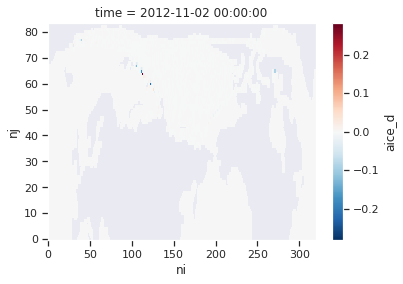

In [15]:
(wind_exp.aice_d - control.aice_d).sel(nj=slice(300,384)).plot()

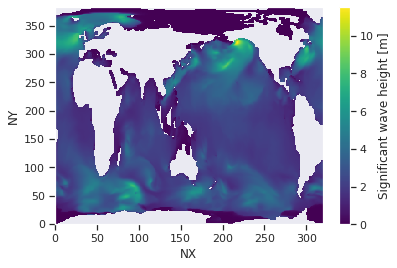

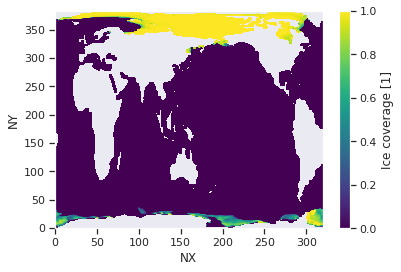

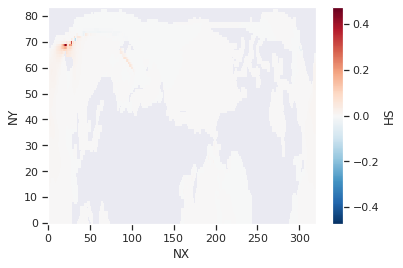

In [103]:
control_ww.HS.plot()
plt.show()

wind_exp_ww.ICE.plot()
plt.show()

(wind_exp_ww.HS - control_ww.HS).sel(NY=slice(300,384)).plot()
plt.show()

In [ ]:
control_ww.HS.plot()
plt.show()

wind_exp_ww.HS.plot()
plt.show()

(wind_exp_ww.HS - control_ww.HS).sel(NY=slice(300,384)).plot()
plt.show()

In [29]:
hsdiff = wind_exp_ww.HS - control_ww.HS

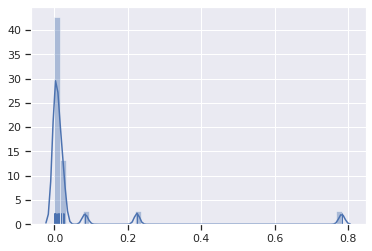

In [46]:
sns.distplot(wind_exp_ww.ICE.values[~np.isnan(hsdiff.where(hsdiff > 0.1).values)],rug=True)

### attempt to use open mf dataset for loading Hs only

In [6]:
import dask
from glob import glob
latslice=slice(300,384)

In [4]:
def preprocess(ds):
    ds = ds[['HS','ICE']]
    ds = ds.expand_dims(time = [datetime.datetime.now()]) ## dummy time
    return ds

In [18]:
mfds = xr.open_dataset('/glade/scratch/vcooper/cesm23iws1tsks_02wind/run/ww2012concat2.nc')
wave_extent_annual = xr.open_dataarray('./wave_extent_annual.nc')
wave_extent = wave_extent_annual.values

In [28]:
# rundir = '/glade/scratch/vcooper/cesm23iws1tsks_02wind/run/'
# flist = 'cesm23iws1tsks_02wind.ww3.hi.2012-*.nc'
# dfiles = sorted(glob(rundir + flist))
# dfiles;
# print(len(dfiles), len(ww2012.time))

In [ ]:
# mfds = xr.open_mfdataset(dfiles,
# #                          combine='nested',
#                          concat_dim='time',
#                          preprocess=preprocess,
#                          parallel=True)
# %%time
# mfds_temp = xr.open_mfdataset(dfiles,
#                               coords='minimal',
#                               concat_dim='time',
#                               compat='override',
#                               preprocess=preprocess,
#                               parallel=False)

In [ ]:
# %%time
# mfds_temp.load()

In [ ]:
# mfds_temp['time'] = ww2012.time
# # mfds_temp#.load()

In [5]:
latslice=slice(300,384)

In [27]:
%%time
wave_extent2 = xr.where(
    (mfds.HS.sel(NY=latslice) > 0.1) & (mfds.ICE.sel(NY=latslice) > 0.15),
    tarea.values[300:,:],0).sum(dim=('NY','NX'))
wave_extent2 = wave_extent2/(1000**2) / 1e6 ## convert to 10^6 km^2

CPU times: user 1.95 s, sys: 1.71 s, total: 3.66 s
Wall time: 13.7 s


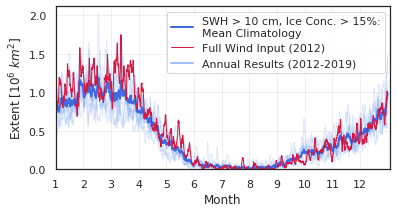

In [31]:
# from cycler import cycler

# color_cyc = [str(i) for i in (np.arange(8)+1)/10]
# color_cyc
# custom_cycler = (cycler(color=color_cyc))

## monthly version of x axis
xx = np.linspace(1,12.999,len(wave_extent[:,0]))

with sns.axes_style('white'):
    fig, ax = plt.subplots(figsize=(6,3),dpi=72)
#     ax.set_prop_cycle(custom_cycler)


    [plt.plot(xx,wave_extent[:,j],alpha=0.2,lw=1,c='cornflowerblue') for j in range(8)]
    
    plt.plot(xx,wave_extent.mean(axis=1),c='royalblue',lw=2,
             label='SWH > 10 cm, Ice Conc. > 15%:\nMean Climatology')
    plt.plot(xx,wave_extent2.values,c='crimson',lw=1,alpha=0.99,
             label='Full Wind Input (2012)')
    
    ## dummy for legend
    plt.plot(xx+10000,wave_extent[:,0],alpha=0.6,lw=2,c='cornflowerblue',label='Annual Results (2012-2019)')
    
    plt.ylim(0,)
    plt.xlim(1,13.1)
    plt.xticks(np.arange(12)+1)
    plt.grid(True,alpha=0.3)
#     plt.title('Wave-Affected Ice Extent ($H_s$ > 10 cm, Ice > 15%)')
    plt.ylabel('Extent [$10^6$ $km^2$]')
    plt.xlabel('Month')
    plt.legend()
    plt.show()

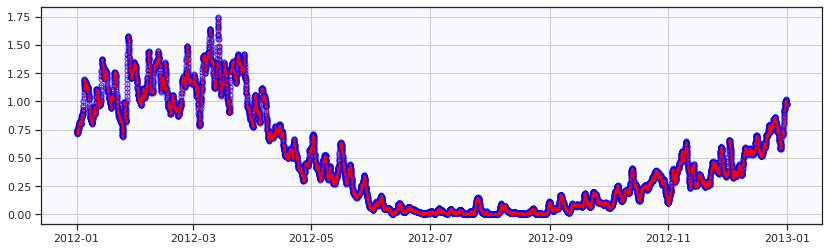

In [29]:
with sns.axes_style('ticks'):
    plt.subplots(figsize=(14,4))
    ax = plt.subplot()
    plt.plot(mfds.time,wave_extent2,marker='o',lw=0,alpha=0.8,mfc='none',c='b',markersize=5)
    plt.plot(mfds.time,wave_extent[:,0],marker='.',lw=0,alpha=0.8,markersize=2,c='r')
    ax.set_facecolor('ghostwhite')
    plt.grid(True)
    # plt.plot(wave_extent[:,7],marker='.',lw=0,alpha=0.2)
    plt.show()

## Check floe radius

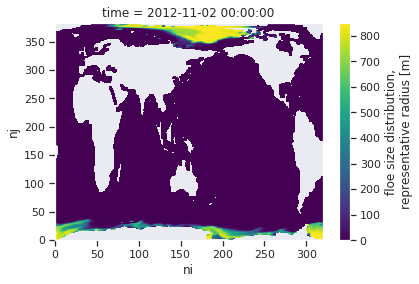

In [10]:
control.fsdrad_d.plot()

In [6]:
## control
control = xr.open_dataset(
    '/glade/scratch/vcooper/cesm23iws1tsks_bittest1/run/cesm23iws1tsks_bittest1.cice.h1.2012-11-01.nc')

# newrun = xr.open_dataset(
#     '/glade/scratch/vcooper/cesm23iws1tsks_bittest1/run/cesm23iws1tsks_bittest1.cice.h1.2013-01-01.nc')
control['TLON'] = (grid.lon.dims, grid.lon.values)
control['TLAT'] = (grid.lat.dims, grid.lat.values)
# newrun = newrun.sel(nj=slice(280,384)).squeeze()
control = control.squeeze()

In [7]:
!ls /glade/scratch/vcooper/cesm23iws1tsks_bittest1/run/cesm23iws1tsks_bittest1.cice.h1.2012*.nc

/glade/scratch/vcooper/cesm23iws1tsks_bittest1/run/cesm23iws1tsks_bittest1.cice.h1.2012-01-01.nc
/glade/scratch/vcooper/cesm23iws1tsks_bittest1/run/cesm23iws1tsks_bittest1.cice.h1.2012-01-02.nc
/glade/scratch/vcooper/cesm23iws1tsks_bittest1/run/cesm23iws1tsks_bittest1.cice.h1.2012-01-03.nc
/glade/scratch/vcooper/cesm23iws1tsks_bittest1/run/cesm23iws1tsks_bittest1.cice.h1.2012-01-04.nc
/glade/scratch/vcooper/cesm23iws1tsks_bittest1/run/cesm23iws1tsks_bittest1.cice.h1.2012-01-05.nc
/glade/scratch/vcooper/cesm23iws1tsks_bittest1/run/cesm23iws1tsks_bittest1.cice.h1.2012-01-06.nc
/glade/scratch/vcooper/cesm23iws1tsks_bittest1/run/cesm23iws1tsks_bittest1.cice.h1.2012-01-07.nc
/glade/scratch/vcooper/cesm23iws1tsks_bittest1/run/cesm23iws1tsks_bittest1.cice.h1.2012-01-08.nc
/glade/scratch/vcooper/cesm23iws1tsks_bittest1/run/cesm23iws1tsks_bittest1.cice.h1.2012-01-09.nc
/glade/scratch/vcooper/cesm23iws1tsks_bittest1/run/cesm23iws1tsks_bittest1.cice.h1.2012-01-10.nc
/glade/scratch/vcooper/cesm23i

In [7]:
def preprocess(ds):
    ds = ds[['aice_d','hi_d','fsdrad_d']].sel(nj=latslice)
#     ds = ds.expand_dims(time = [datetime.datetime.now()]) ## dummy time
    return ds

In [8]:
rundir = '/glade/scratch/vcooper/cesm23iws1tsks_bittest1/run/'
flist = 'cesm23iws1tsks_bittest1.cice.h1.2012-*.nc'
dfiles = sorted(glob(rundir + flist))
dfiles;
print(len(dfiles))

365


In [9]:
%%time
control_sub = xr.open_mfdataset(dfiles,
                              coords='minimal',
                              concat_dim='time',
                              compat='override',
                              preprocess=preprocess,
                              parallel=True)

CPU times: user 14.8 s, sys: 601 ms, total: 15.4 s
Wall time: 32.1 s


In [10]:
%%time
control_sub.load()

CPU times: user 2.45 s, sys: 553 ms, total: 3 s
Wall time: 1min 40s


<xarray.Dataset>
Dimensions:   (ni: 320, nj: 84, time: 365)
Coordinates:
  * time      (time) object 2012-01-02 00:00:00 ... 2013-01-01 00:00:00
    TLON      (nj, ni) float32 320.5504 321.65125 322.75208 ... nan nan nan
    TLAT      (nj, ni) float32 39.137207 39.138866 39.14219 ... nan nan nan
    ULON      (nj, ni) float32 321.1003 322.20062 323.30093 ... nan nan nan
    ULAT      (nj, ni) float32 39.34804 39.350563 39.354767 ... nan nan nan
Dimensions without coordinates: ni, nj
Data variables:
    aice_d    (time, nj, ni) float32 0.0 0.0 0.0 0.0 0.0 ... nan nan nan nan nan
    hi_d      (time, nj, ni) float32 0.0 0.0 0.0 0.0 0.0 ... nan nan nan nan nan
    fsdrad_d  (time, nj, ni) float32 0.0 0.0 0.0 0.0 0.0 ... nan nan nan nan nan
Attributes:
    title:             cesm23iws1tsks_bittest1
    contents:          Diagnostic and Prognostic Variables
    source:            Los Alamos Sea Ice Model (CICE) Version 5
    time_period_freq:  day_1
    model_doi_url:     
    comment:           All years have exactly 365 days
    comment2:          File written on model date 20120102
    comment3:          seconds elapsed into model date:      0
    conventions:       CF-1.0
    history:           This dataset was created on 2021-08-03 at 12:10
    io_flavor:         io_pio

In [11]:
control_sub['TLON'] = (grid.lon.sel(nj=latslice).dims, grid.lon[300:].values)
control_sub['TLAT'] = (grid.lat.sel(nj=latslice).dims, grid.lat[300:].values)

In [12]:
%%time
## experiment
rundir = '/glade/scratch/vcooper/cesm23iws1tsks_mltest1/run/'
flist = 'cesm23iws1tsks_mltest1.cice.h1.2012-*.nc'
dfiles = sorted(glob(rundir + flist))
dfiles;
print(len(dfiles))

mlexp_sub = xr.open_mfdataset(dfiles,
                              coords='minimal',
                              concat_dim='time',
                              compat='override',
                              preprocess=preprocess,
                              parallel=True)
mlexp_sub['TLON'] = (grid.lon.sel(nj=latslice).dims, grid.lon[300:].values)
mlexp_sub['TLAT'] = (grid.lat.sel(nj=latslice).dims, grid.lat[300:].values)


mlexp_sub.load()

365
CPU times: user 17.7 s, sys: 1.12 s, total: 18.8 s
Wall time: 2min 12s


<xarray.Dataset>
Dimensions:   (ni: 320, nj: 84, time: 365)
Coordinates:
  * time      (time) object 2012-01-02 00:00:00 ... 2013-01-01 00:00:00
    TLON      (nj, ni) float64 320.6 321.7 322.8 ... 9.969e+36 9.969e+36
    TLAT      (nj, ni) float64 39.14 39.14 39.14 ... 9.969e+36 9.969e+36
    ULON      (nj, ni) float32 321.1003 322.20062 323.30093 ... nan nan nan
    ULAT      (nj, ni) float32 39.34804 39.350563 39.354767 ... nan nan nan
Dimensions without coordinates: ni, nj
Data variables:
    aice_d    (time, nj, ni) float32 0.0 0.0 0.0 0.0 0.0 ... nan nan nan nan nan
    hi_d      (time, nj, ni) float32 0.0 0.0 0.0 0.0 0.0 ... nan nan nan nan nan
    fsdrad_d  (time, nj, ni) float32 0.0 0.0 0.0 0.0 0.0 ... nan nan nan nan nan
Attributes:
    title:             cesm23iws1tsks_mltest1
    contents:          Diagnostic and Prognostic Variables
    source:            Los Alamos Sea Ice Model (CICE) Version 5
    time_period_freq:  day_1
    model_doi_url:     
    comment:           All years have exactly 365 days
    comment2:          File written on model date 20120102
    comment3:          seconds elapsed into model date:      0
    conventions:       CF-1.0
    history:           This dataset was created on 2021-08-12 at 15:05
    io_flavor:         io_pio

In [13]:
## experiment
rundir = '/glade/scratch/vcooper/cesm23iws1tsks_02wind/run/'
flist = 'cesm23iws1tsks_02wind.cice.h1.2012-*.nc'
dfiles = sorted(glob(rundir + flist))
dfiles;
print(len(dfiles))

365


In [14]:
%%time
exp_sub = xr.open_mfdataset(dfiles,
                              coords='minimal',
                              concat_dim='time',
                              compat='override',
                              preprocess=preprocess,
                              parallel=True)
exp_sub['TLON'] = (grid.lon.sel(nj=latslice).dims, grid.lon[300:].values)
exp_sub['TLAT'] = (grid.lat.sel(nj=latslice).dims, grid.lat[300:].values)

CPU times: user 15.3 s, sys: 684 ms, total: 16 s
Wall time: 34.7 s


In [15]:
%%time
exp_sub.load()

CPU times: user 2.5 s, sys: 584 ms, total: 3.09 s
Wall time: 1min 34s


<xarray.Dataset>
Dimensions:   (ni: 320, nj: 84, time: 365)
Coordinates:
  * time      (time) object 2012-01-02 00:00:00 ... 2013-01-01 00:00:00
    TLON      (nj, ni) float64 320.6 321.7 322.8 ... 9.969e+36 9.969e+36
    TLAT      (nj, ni) float64 39.14 39.14 39.14 ... 9.969e+36 9.969e+36
    ULON      (nj, ni) float32 321.1003 322.20062 323.30093 ... nan nan nan
    ULAT      (nj, ni) float32 39.34804 39.350563 39.354767 ... nan nan nan
Dimensions without coordinates: ni, nj
Data variables:
    aice_d    (time, nj, ni) float32 0.0 0.0 0.0 0.0 0.0 ... nan nan nan nan nan
    hi_d      (time, nj, ni) float32 0.0 0.0 0.0 0.0 0.0 ... nan nan nan nan nan
    fsdrad_d  (time, nj, ni) float32 0.0 0.0 0.0 0.0 0.0 ... nan nan nan nan nan
Attributes:
    title:             cesm23iws1tsks_02wind
    contents:          Diagnostic and Prognostic Variables
    source:            Los Alamos Sea Ice Model (CICE) Version 5
    time_period_freq:  day_1
    model_doi_url:     
    comment:           All years have exactly 365 days
    comment2:          File written on model date 20120102
    comment3:          seconds elapsed into model date:      0
    conventions:       CF-1.0
    history:           This dataset was created on 2021-08-12 at 18:24
    io_flavor:         io_pio

In [25]:
meanrad_control = (control_sub.fsdrad_d.where(control_sub.aice_d > 0.15) * tarea.sel(nj=latslice).values).sum(axis=(1,2)) / (
    tarea.sel(nj=latslice).sum().values)

meanrad_exp = (exp_sub.fsdrad_d.where(exp_sub.aice_d > 0.15) * tarea.sel(nj=latslice).values).sum(axis=(1,2)) / (
    tarea.sel(nj=latslice).sum().values)

meanrad_control = (control_sub.fsdrad_d.where(control_sub.aice_d > 0.15) * tarea.sel(nj=latslice).values).sum(axis=(1,2)) / (
    tarea.sel(nj=latslice).sum().values)

meanrad_exp = (exp_sub.fsdrad_d.where(exp_sub.aice_d > 0.15) * tarea.sel(nj=latslice).values).sum(axis=(1,2)) / (
    tarea.sel(nj=latslice).sum().values)

In [92]:
meanrad_mlexp = (mlexp_sub.fsdrad_d.where(exp_sub.aice_d > 0.15) * tarea.sel(nj=latslice).values).sum(axis=(1,2)) / (
    tarea.sel(nj=latslice).sum().values)

Text(0.5, 1.0, 'Mean Floe Radius where SIC > 15%')

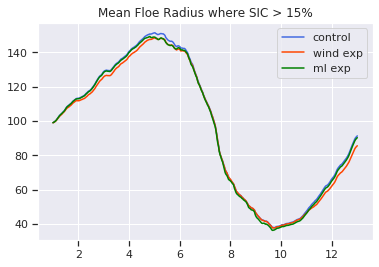

In [94]:
plt.plot(np.linspace(1,12.999,365),meanrad_control.values,c='royalblue',label='control')
plt.plot(np.linspace(1,12.999,365),meanrad_exp.values,c='orangered',label='wind exp')
plt.plot(np.linspace(1,12.999,365),meanrad_mlexp.values,c='g',label='ml exp')
# plt.xlim(0,13)
plt.legend()
plt.title('Mean Floe Radius where SIC > 15%')

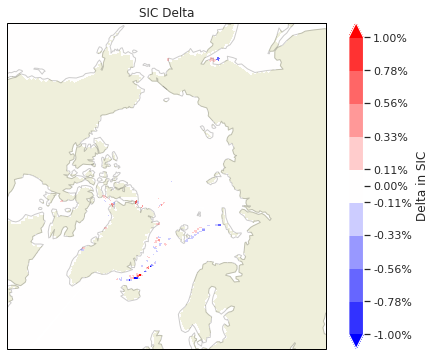

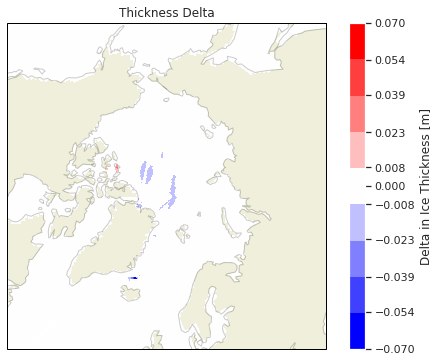

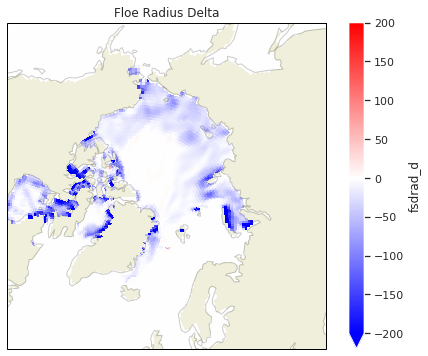

In [87]:
dind = -1

proj = ccrs.NorthPolarStereo()

fig = plt.subplots(figsize=(8,6))
ax = plt.subplot(projection=proj)
ax.set_extent([0.005, 360, 55, 90], crs=ccrs.PlateCarree())
ax.coastlines(alpha=0.2,lw=1)
# plt.pcolormesh(control_sub.TLON, control_sub.TLAT,
#                exp_sub.aice_d[dind] - control_sub.aice_d[dind],
#                cmap='bwr',vmax=.01,vmin=-.01,levels=10, transform=ccrs.PlateCarree())
pcol = ((exp_sub.aice_d[dind] - control_sub.aice_d[dind])*100).plot.pcolormesh('TLON', 'TLAT',
    cmap='bwr',vmax=1,vmin=-1,levels=10,add_colorbar=False,
    ax=ax,transform=ccrs.PlateCarree())
plt.colorbar(pcol,label='Delta in SIC',
             ticks=np.round(np.append(np.linspace(-1,1,10),0),2),
             format=mpl.ticker.PercentFormatter()) #'%.1f\%')
plt.title('SIC Delta')
ax.add_feature(cfeature.LAND)
plt.show()

fig = plt.subplots(figsize=(8,6))
ax = plt.subplot(projection=proj)
ax.set_extent([0.005, 360, 55, 90], crs=ccrs.PlateCarree())
ax.coastlines(alpha=0.2,lw=1)
pcol2 = (exp_sub.hi_d[dind] - control_sub.hi_d[dind]).plot.pcolormesh('TLON', 'TLAT',
    cmap='bwr',vmax=.07,vmin=-.07,levels=10,add_colorbar=False,
    ax=ax,transform=ccrs.PlateCarree())
plt.colorbar(pcol2,label='Delta in Ice Thickness [m]',
             ticks=np.round(np.append(np.linspace(-.07,.07,10),0),3))
#              format='%.2f')
plt.title('Thickness Delta')
ax.add_feature(cfeature.LAND)
plt.show()

fig = plt.subplots(figsize=(8,6))
ax = plt.subplot(projection=proj)
ax.set_extent([0.005, 360, 55, 90], crs=ccrs.PlateCarree())
ax.coastlines(alpha=0.2,lw=1)
pcol3 = (exp_sub.fsdrad_d[dind] - control_sub.fsdrad_d[dind]).plot.pcolormesh('TLON', 'TLAT',
    cmap='bwr',vmax=200,vmin=-200,#levels=11,add_colorbar=False,
    ax=ax,transform=ccrs.PlateCarree())
# plt.colorbar(pcol3,label='Delta in Floe Radius [m]')
#             ticks=np.append(np.linspace(-200,200,10),0),extend='neither')
#              format='%.2f')
# plt.pcolormesh(control_sub.TLON, control_sub.TLAT,
#                exp_sub.fsdrad_d[dind] - control_sub.fsdrad_d[dind],
#                transform=ccrs.PlateCarree(),
#                cmap='bwr',vmax=100,vmin=-100,levels=10)
plt.title('Floe Radius Delta')
ax.add_feature(cfeature.LAND)
plt.show()

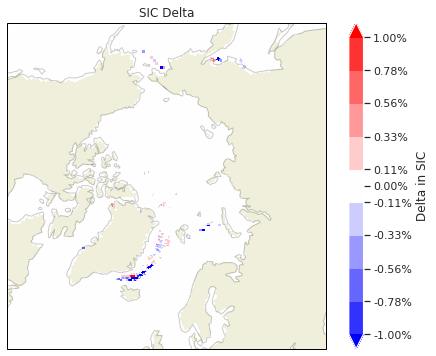

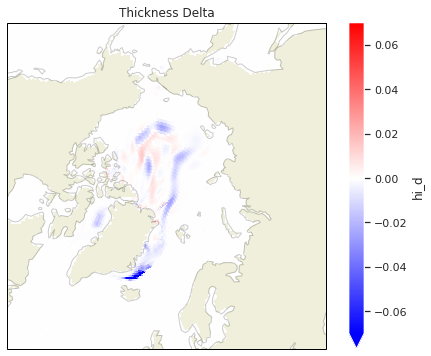

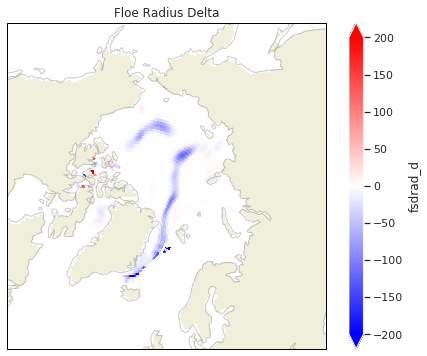

In [96]:
dind = -1

proj = ccrs.NorthPolarStereo()

fig = plt.subplots(figsize=(8,6))
ax = plt.subplot(projection=proj)
ax.set_extent([0.005, 360, 55, 90], crs=ccrs.PlateCarree())
ax.coastlines(alpha=0.2,lw=1)
# plt.pcolormesh(control_sub.TLON, control_sub.TLAT,
#                mlexp_sub.aice_d[dind] - control_sub.aice_d[dind],
#                cmap='bwr',vmax=.01,vmin=-.01,levels=10, transform=ccrs.PlateCarree())
pcol = ((mlexp_sub.aice_d[dind] - control_sub.aice_d[dind])*100).plot.pcolormesh('TLON', 'TLAT',
    cmap='bwr',vmax=1,vmin=-1,levels=10,add_colorbar=False,
    ax=ax,transform=ccrs.PlateCarree())
plt.colorbar(pcol,label='Delta in SIC',
             ticks=np.round(np.append(np.linspace(-1,1,10),0),2),
             format=mpl.ticker.PercentFormatter()) #'%.1f\%')
plt.title('SIC Delta')
ax.add_feature(cfeature.LAND)
plt.show()

fig = plt.subplots(figsize=(8,6))
ax = plt.subplot(projection=proj)
ax.set_extent([0.005, 360, 55, 90], crs=ccrs.PlateCarree())
ax.coastlines(alpha=0.2,lw=1)
pcol2 = (mlexp_sub.hi_d[dind] - control_sub.hi_d[dind]).plot.pcolormesh('TLON', 'TLAT',
    cmap='bwr',vmax=.07,vmin=-.07,#levels=10,add_colorbar=False,
    ax=ax,transform=ccrs.PlateCarree())
# plt.colorbar(pcol2,label='Delta in Ice Thickness [m]',
#              ticks=np.round(np.append(np.linspace(-.07,.07,10),0),3))
# #              format='%.2f')
plt.title('Thickness Delta')
ax.add_feature(cfeature.LAND)
plt.show()

fig = plt.subplots(figsize=(8,6))
ax = plt.subplot(projection=proj)
ax.set_extent([0.005, 360, 55, 90], crs=ccrs.PlateCarree())
ax.coastlines(alpha=0.2,lw=1)
pcol3 = (mlexp_sub.fsdrad_d[dind] - control_sub.fsdrad_d[dind]).plot.pcolormesh('TLON', 'TLAT',
    cmap='bwr',vmax=200,vmin=-200,#levels=11,add_colorbar=False,
    ax=ax,transform=ccrs.PlateCarree())
# plt.colorbar(pcol3,label='Delta in Floe Radius [m]')
#             ticks=np.append(np.linspace(-200,200,10),0),extend='neither')
#              format='%.2f')
# plt.pcolormesh(control_sub.TLON, control_sub.TLAT,
#                mlexp_sub.fsdrad_d[dind] - control_sub.fsdrad_d[dind],
#                transform=ccrs.PlateCarree(),
#                cmap='bwr',vmax=100,vmin=-100,levels=10)
plt.title('Floe Radius Delta')
ax.add_feature(cfeature.LAND)
plt.show()

## Check spectrum in model

In [2]:
wind_exp_ww = xr.open_dataset(
    '/glade/scratch/vcooper/cesm23iws1tsks_02wind/run/cesm23iws1tsks_02wind.ww3.hi.2012-08-10-00000.nc')

control_ww = xr.open_dataset(
    '/glade/scratch/vcooper/cesm23iws1tsks_bittest1/run/cesm23iws1tsks_bittest1.ww3.hi.2012-08-10-00000.nc')
temp_f = xr.open_dataset('./ww1719ef_beau_cat.nc')
wind_exp_ww = wind_exp_ww.assign_coords({'FREQ':temp_f.f.values})
control_ww = control_ww.assign_coords({'FREQ':temp_f.f.values})
wind_exp_ww['TLON'] = (wind_exp_ww.HS.dims, grid.lon.values)
wind_exp_ww['TLAT'] = (wind_exp_ww.HS.dims, grid.lat.values)
control_ww['TLON'] = (wind_exp_ww.HS.dims, grid.lon.values)
control_ww['TLAT'] = (wind_exp_ww.HS.dims, grid.lat.values)

wind_exp_cice = xr.open_dataset(
    '/glade/scratch/vcooper/cesm23iws1tsks_02wind/run/cesm23iws1tsks_02wind.cice.h1.2012-08-10.nc')

control_cice = xr.open_dataset(
    '/glade/scratch/vcooper/cesm23iws1tsks_bittest1/run/cesm23iws1tsks_bittest1.cice.h1.2012-08-10.nc')



In [34]:
## repeat for different date
wind_exp_ww = xr.open_dataset(
    '/glade/scratch/vcooper/cesm23iws1tsks_02wind/run/cesm23iws1tsks_02wind.ww3.hi.2012-10-10-00000.nc')

control_ww = xr.open_dataset(
    '/glade/scratch/vcooper/cesm23iws1tsks_bittest1/run/cesm23iws1tsks_bittest1.ww3.hi.2012-10-10-00000.nc')
temp_f = xr.open_dataset('./ww1719ef_beau_cat.nc')
wind_exp_ww = wind_exp_ww.assign_coords({'FREQ':temp_f.f.values})
control_ww = control_ww.assign_coords({'FREQ':temp_f.f.values})
wind_exp_ww['TLON'] = (wind_exp_ww.HS.dims, grid.lon.values)
wind_exp_ww['TLAT'] = (wind_exp_ww.HS.dims, grid.lat.values)
control_ww['TLON'] = (wind_exp_ww.HS.dims, grid.lon.values)
control_ww['TLAT'] = (wind_exp_ww.HS.dims, grid.lat.values)

wind_exp_cice = xr.open_dataset(
    '/glade/scratch/vcooper/cesm23iws1tsks_02wind/run/cesm23iws1tsks_02wind.cice.h1.2012-10-10.nc')

control_cice = xr.open_dataset(
    '/glade/scratch/vcooper/cesm23iws1tsks_bittest1/run/cesm23iws1tsks_bittest1.cice.h1.2012-10-10.nc')


In [8]:
latmin = 72
latmax = 79
lonmin = 195
lonmax = 230
dist_model = xr.open_dataarray(
    '/glade/work/vcooper/BGEP_vtc/model_iceedgedistance_2000-2019.nc')
beau_mask = (
    (dist_model.coords['longitude'] > lonmin) 
    & (dist_model.coords['longitude'] < lonmax)
    & (dist_model.coords['latitude'] > latmin)
    & (dist_model.coords['latitude'] < latmax)
)

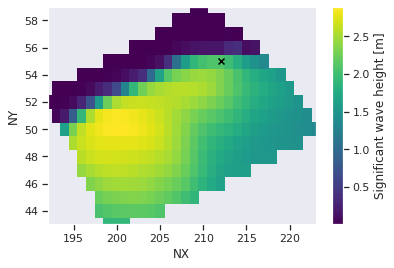

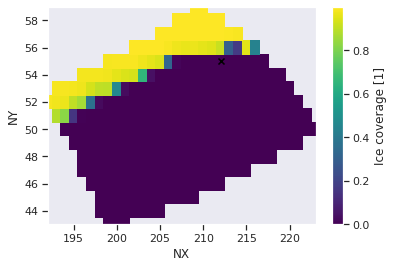

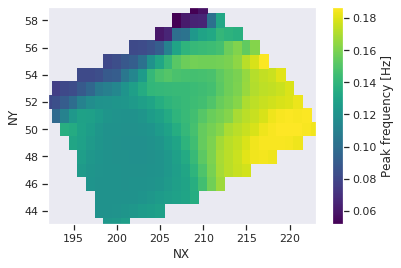

In [9]:
wind_exp_ww.HS.sel(NY=latslice).where(beau_mask.values).plot()
plt.xlim(beau_mask.ni.where(beau_mask).min(),
         beau_mask.ni.where(beau_mask).max())
plt.ylim(beau_mask.nj.where(beau_mask).min(),
         beau_mask.nj.where(beau_mask).max())
plt.scatter(212,55,marker='x',c='k')
plt.show()

wind_exp_ww.ICE.sel(NY=latslice).where(beau_mask.values).plot()
plt.xlim(beau_mask.ni.where(beau_mask).min(),
         beau_mask.ni.where(beau_mask).max())
plt.ylim(beau_mask.nj.where(beau_mask).min(),
         beau_mask.nj.where(beau_mask).max())
plt.scatter(212,55,marker='x',c='k')
plt.show()

wind_exp_ww.FP0.sel(NY=latslice).where(beau_mask.values).plot()
plt.xlim(beau_mask.ni.where(beau_mask).min(),
         beau_mask.ni.where(beau_mask).max())
plt.ylim(beau_mask.nj.where(beau_mask).min(),
         beau_mask.nj.where(beau_mask).max())
plt.show()

In [73]:
np.rad2deg(wind_exp_ww.THM[55,212])
wind_exp_ww.THM[55,212]

<xarray.DataArray 'THM' ()>
array(-2.262313)
Attributes:
    units:      rad
    long_name:  Mean wave direction

In [77]:
np.arctan(wind_exp_ww.UAY[55,212]/wind_exp_ww.UAX[55,212])
# wind_exp_ww.UAY[55,212]
# wind_exp_ww.UAX[55,212]

<xarray.DataArray ()>
array(-0.26110964)

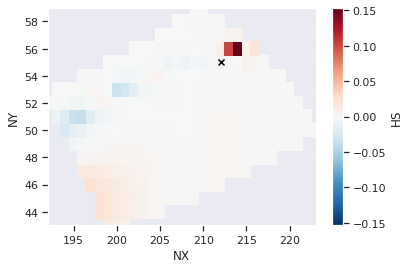

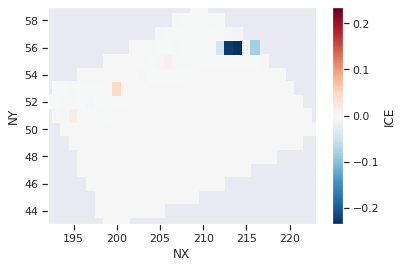

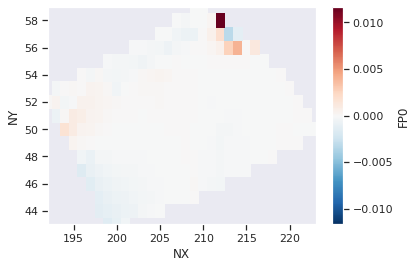

In [287]:
(wind_exp_ww.HS - control_ww.HS).sel(NY=latslice).where(beau_mask.values).plot()
plt.xlim(beau_mask.ni.where(beau_mask).min(),
         beau_mask.ni.where(beau_mask).max())
plt.ylim(beau_mask.nj.where(beau_mask).min(),
         beau_mask.nj.where(beau_mask).max())
plt.scatter(212,55,marker='x',c='k')
plt.show()

(wind_exp_ww.ICE - control_ww.ICE).sel(NY=latslice).where(beau_mask.values).plot()
plt.xlim(beau_mask.ni.where(beau_mask).min(),
         beau_mask.ni.where(beau_mask).max())
plt.ylim(beau_mask.nj.where(beau_mask).min(),
         beau_mask.nj.where(beau_mask).max())
plt.show()

(wind_exp_ww.FP0 - control_ww.FP0).sel(NY=latslice).where(beau_mask.values).plot()
plt.xlim(beau_mask.ni.where(beau_mask).min(),
         beau_mask.ni.where(beau_mask).max())
plt.ylim(beau_mask.nj.where(beau_mask).min(),
         beau_mask.nj.where(beau_mask).max())
plt.show()

In [293]:
wind_exp_ww_sub = wind_exp_ww.sel(NY=latslice)
control_ww_sub = control_ww.sel(NY=latslice)

In [296]:
temp = wind_exp_ww_sub.HS.where(beau_mask.values).where(
                     (wind_exp_ww_sub.ICE > 0.15)).argmax(dim=['NY','NX'])


wind_exp_ww_sub.HS.where(beau_mask.values).where(
                     (wind_exp_ww_sub.ICE > 0.15)).argmax(dim=['NY','NX'])

{'NY': <xarray.DataArray 'HS' ()>
 array(51),
 'NX': <xarray.DataArray 'HS' ()>
 array(195)}

In [303]:
print((wind_exp_ww_sub.UAX[temp['NY'],temp['NX']]**2 + wind_exp_ww_sub.UAX[temp['NY'],temp['NX']]**2)**(0.5))
print(wind_exp_ww_sub.HS[temp['NY'],temp['NX']])
print(wind_exp_ww_sub.ICE[temp['NY'],temp['NX']])

<xarray.DataArray 'UAX' ()>
array(18.862778, dtype=float32)
<xarray.DataArray 'HS' ()>
array(0.85586, dtype=float32)
Attributes:
    units:      m
    long_name:  Significant wave height
<xarray.DataArray 'ICE' ()>
array(0.155445, dtype=float32)
Attributes:
    units:      1
    long_name:  Ice coverage


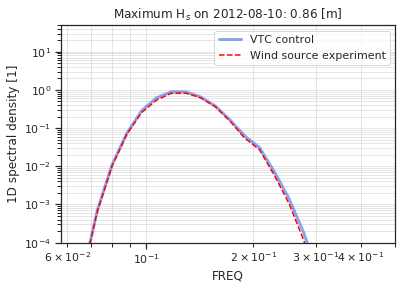

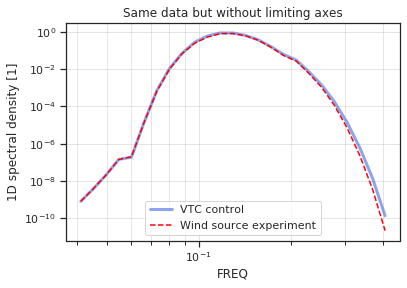

In [304]:
with sns.axes_style('ticks'):
    plt.grid(True,which='both',alpha=0.5)
    control_ww_sub.EF[:,temp['NY'],temp['NX']].plot(c='royalblue',alpha=0.6,lw=3,label='VTC control')
    wind_exp_ww_sub.EF[:,temp['NY'],temp['NX']].plot(c='r',ls='--',label='Wind source experiment')
    plt.loglog()
    # plt.xlim(0.06,0.5)
    # plt.ylim(.01,10)
    plt.xlim(10**(-1.24),10**(-0.3))
    plt.ylim(10**(-4),5*10**(1))
    plt.title('Maximum H$_s$ on 2012-08-10: '+ str(np.round(wind_exp_ww_sub.HS[temp['NY'],temp['NX']].values,2)) + ' [m]')
    plt.legend()
    plt.show()
    
    plt.grid(True,which='both',alpha=0.5)
    control_ww_sub.EF[:,temp['NY'],temp['NX']].plot(c='royalblue',alpha=0.6,lw=3,label='VTC control')
    wind_exp_ww_sub.EF[:,temp['NY'],temp['NX']].plot(c='r',ls='--',label='Wind source experiment')
    plt.loglog()
    # plt.xlim(0.06,0.5)
    # plt.ylim(.01,10)
#     plt.xlim(10**(-1.24),10**(-0.3))
#     plt.ylim(10**(-4),5*10**(1))
    plt.title('Same data but without limiting axes')
    plt.legend()
    plt.show()

In [108]:
temp = wind_exp_ww.FP0.where((wind_exp_ww.ICE > 0.01) & 
                      (wind_exp_ww.HS > 0.2)).sel(NY=latslice).argmax(dim=['NY','NX'])

wind_exp_ww.FP0.where((wind_exp_ww.ICE > 0.01) & 
                      (wind_exp_ww.HS > 0.2)).sel(NY=latslice).argmax(dim=['NY','NX'])

{'NY': <xarray.DataArray 'FP0' ()>
 array(46),
 'NX': <xarray.DataArray 'FP0' ()>
 array(180)}

In [109]:
wind_exp_ww.sel(NY=latslice).FP0[temp['NY'],temp['NX']]

<xarray.DataArray 'FP0' ()>
array(0.150879)
Attributes:
    units:      Hz
    long_name:  Peak frequency

In [318]:
temp = wind_exp_ww.FP0.where((wind_exp_ww.HS  > 0.3 ) & 
                             (wind_exp_ww.ICE > 0.15)).sel(NY=latslice).argmax(dim=['NY','NX'])
print(temp)

{'NY': <xarray.DataArray 'FP0' ()>
array(56), 'NX': <xarray.DataArray 'FP0' ()>
array(214)}


In [61]:
def npolarplot(lowlat):
    proj = ccrs.NorthPolarStereo()#central_longitude=179-360)
    ax = plt.subplot(projection=proj)
    ax.coastlines(alpha=0.2,lw=1)
    ax.set_extent([-180,180,lowlat,90], ccrs.PlateCarree())
    ax.add_feature(cfeature.LAND)
#     ax.gridlines()
#     ax.set_boundary(circle, transform=ax.transAxes)
#     ax.add_feature(cfeature.LAND,zorder=6)

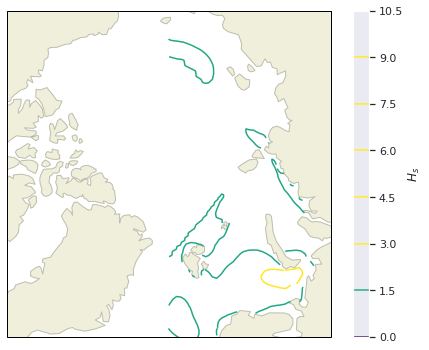

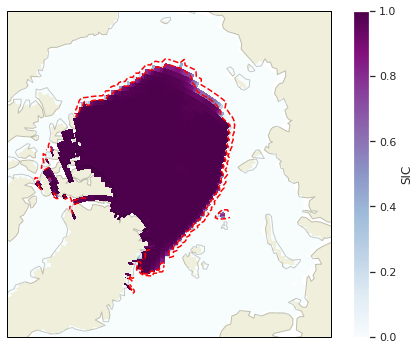

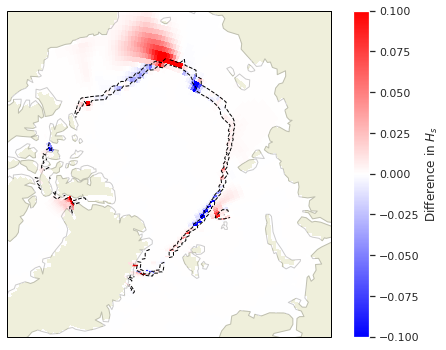

In [162]:
minlat = 70
fig = plt.subplots(figsize=(8,6))
npolarplot(minlat)
# plt.contourf(wind_exp_ww.TLON,wind_exp_ww.TLAT,wind_exp_ww.HS.where(wind_exp_ww.TLON > 180),
#                vmin=0.00,vmax=2,cmap='viridis',levels=5,
#                transform=ccrs.PlateCarree())
plt.contour(wind_exp_ww.TLON,wind_exp_ww.TLAT,wind_exp_ww.HS.where(wind_exp_ww.TLON < 180),
               vmin=0.00,vmax=2.5,cmap='viridis',
               transform=ccrs.PlateCarree())
plt.colorbar(label='$H_s$')
plt.show()

fig = plt.subplots(figsize=(8,6))
npolarplot(minlat)
plt.pcolormesh(wind_exp_ww.TLON,wind_exp_ww.TLAT,wind_exp_ww.ICE,
               vmin=0.00,vmax=1,cmap='BuPu',
               transform=ccrs.PlateCarree())
plt.colorbar(label='SIC')
plt.contour(wind_exp_ww.TLON,wind_exp_ww.TLAT,
            wind_exp_ww.ICE.where(wind_exp_ww.TLON > 180),
            levels=[0.01,0.8],colors='r',linestyles='--',
            transform=ccrs.PlateCarree())
plt.contour(wind_exp_ww.TLON,wind_exp_ww.TLAT,
            wind_exp_ww.ICE.where(wind_exp_ww.TLON < 180),
            levels=[0.01,0.8],colors='r',linestyles='--',
            transform=ccrs.PlateCarree())
plt.show()

fig = plt.subplots(figsize=(8,6))
npolarplot(minlat)
plt.pcolormesh(wind_exp_ww.TLON,wind_exp_ww.TLAT,wind_exp_ww.HS - control_ww.HS,
               vmin=-0.1,vmax=0.1,cmap='bwr',
               transform=ccrs.PlateCarree())
plt.colorbar(label='Difference in $H_s$')
plt.contour(wind_exp_ww.TLON,wind_exp_ww.TLAT,
            wind_exp_ww.ICE.where(wind_exp_ww.TLON > 180),
            levels=[0.01,0.8],colors='k',linestyles='--',linewidths=1,
            transform=ccrs.PlateCarree())
plt.contour(wind_exp_ww.TLON,wind_exp_ww.TLAT,
            wind_exp_ww.ICE.where(wind_exp_ww.TLON < 180),
            levels=[0.01,0.8],colors='k',linestyles='--',linewidths=1,
            transform=ccrs.PlateCarree())
plt.show()

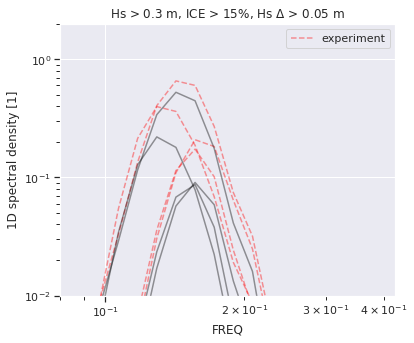

In [154]:
## get all spectra where difference exceeds some value
masksel = xr.where((wind_exp_ww.TLAT > 0) & 
                   (wind_exp_ww.ICE > 0.15) & 
                   (wind_exp_ww.HS  > 0.3) &
                   ((wind_exp_ww.HS - control_ww.HS) > 0.05),True,False)
stacked = wind_exp_ww.EF.where(masksel,drop=True).stack(cell=('NX','NY'))
stacked_c = control_ww.EF.where(masksel,drop=True).stack(cell=('NX','NY'))

stacked = stacked.where(np.any(~np.isnan(stacked),axis=0),drop=True)
stacked_c = stacked_c.where(np.any(~np.isnan(stacked),axis=0),drop=True)

fig = plt.subplots(1,1,figsize=(6,5),sharey=True,sharex=True)
plt.subplot(111)
stacked.plot.line(x='FREQ',add_legend=False,alpha=0.4,ls='--',c='r')
stacked_c.plot.line(x='FREQ',add_legend=False,alpha=0.4,c='k')
plt.ylim(10**-2,2)
plt.xlim(0.08,)
plt.legend(['experiment'])
plt.loglog()
plt.title('Hs > 0.3 m, ICE > 15%, Hs $\Delta$ > 0.05 m')
plt.show()

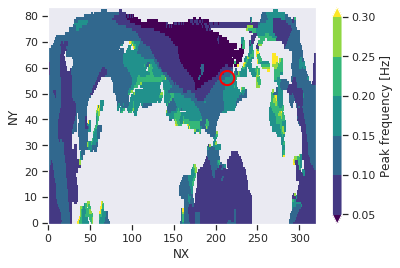

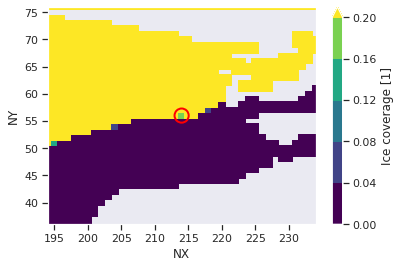

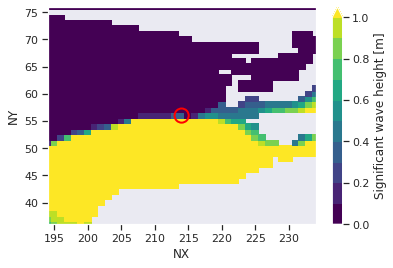

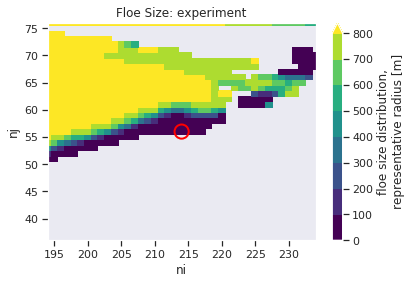

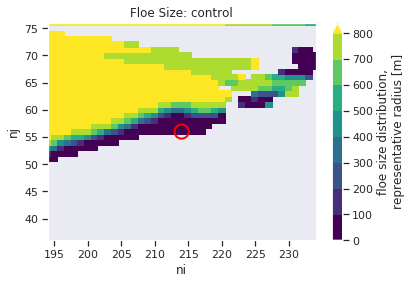

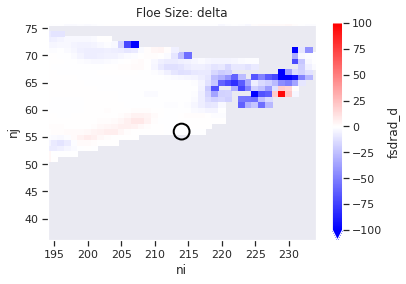

In [329]:
# npolarplot(55)
wind_exp_ww.FP0.sel(NY=latslice).plot(vmin=0.05,vmax=0.3,levels=6)
plt.scatter(temp['NX'],temp['NY'],marker='o',edgecolor='r',facecolor='none',lw=2,s=200)
# plt.xlim(temp['NX']-20,temp['NX']+20)
# plt.ylim(temp['NY']-20,temp['NY']+20)
plt.show()

wind_exp_ww.ICE.sel(NY=latslice).plot(vmin=0,vmax=0.2,levels=6)
# (wind_exp_ww.ICE - control_ww.ICE).sel(NY=latslice).plot(vmin=-.1,vmax=.1,cmap='bwr')#,levels=11)
plt.scatter(temp['NX'],temp['NY'],marker='o',edgecolor='r',facecolor='none',lw=2,s=200)
plt.xlim(temp['NX']-20,temp['NX']+20)
plt.ylim(temp['NY']-20,temp['NY']+20)
plt.show()

wind_exp_ww.HS.sel(NY=latslice).plot(vmin=0,vmax=1,levels=11)
# (wind_exp_ww.HS - control_ww.HS).sel(NY=latslice).plot(vmin=-.1,vmax=.1,cmap='bwr')#,levels=11)
plt.scatter(temp['NX'],temp['NY'],marker='o',edgecolor='r',facecolor='none',lw=2,s=200)
plt.xlim(temp['NX']-20,temp['NX']+20)
plt.ylim(temp['NY']-20,temp['NY']+20)
plt.show()

wind_exp_cice.fsdrad_d.where(wind_exp_cice.aice_d > 0.01).sel(nj=latslice).plot(vmin=0,vmax=800,levels=9)
plt.scatter(temp['NX'],temp['NY'],marker='o',edgecolor='r',facecolor='none',lw=2,s=200)
plt.xlim(temp['NX']-20,temp['NX']+20)
plt.ylim(temp['NY']-20,temp['NY']+20)
plt.title('Floe Size: experiment')
plt.show()


control_cice.fsdrad_d.where(control_cice.aice_d > 0.01).sel(nj=latslice).plot(vmin=0,vmax=800,levels=9)
plt.scatter(temp['NX'],temp['NY'],marker='o',edgecolor='r',facecolor='none',lw=2,s=200)
plt.xlim(temp['NX']-20,temp['NX']+20)
plt.ylim(temp['NY']-20,temp['NY']+20)
plt.title('Floe Size: control')
plt.show()

(wind_exp_cice.fsdrad_d.where(wind_exp_cice.aice_d > 0.01) - 
 control_cice.fsdrad_d.where(control_cice.aice_d > 0.01)).sel(nj=latslice).plot(cmap='bwr',vmin=-100,vmax=100)
plt.scatter(temp['NX'],temp['NY'],marker='o',edgecolor='k',facecolor='none',lw=2,s=250)
plt.xlim(temp['NX']-20,temp['NX']+20)
plt.ylim(temp['NY']-20,temp['NY']+20)
plt.title('Floe Size: delta')
plt.show()

In [316]:
cwind = np.sqrt(control_ww.UAX**2 + control_ww.UAY**2)
ewind = np.sqrt(wind_exp_ww.UAX**2 + wind_exp_ww.UAY**2)

<xarray.DataArray 'HS' ()>
array(0.24259)
Attributes:
    units:      m
    long_name:  Significant wave height <xarray.DataArray 'HS' ()>
array(0.396014, dtype=float32)
Attributes:
    units:      m
    long_name:  Significant wave height
<xarray.DataArray 'ICE' ()>
array(0.410261)
Attributes:
    units:      1
    long_name:  Ice coverage <xarray.DataArray 'ICE' ()>
array(0.174928, dtype=float32)
Attributes:
    units:      1
    long_name:  Ice coverage
<xarray.DataArray ()>
array(12.754817, dtype=float32)


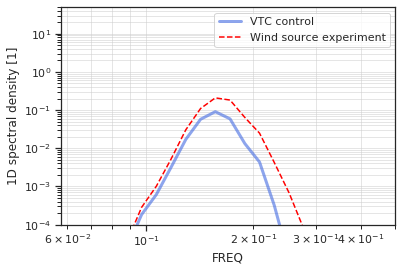

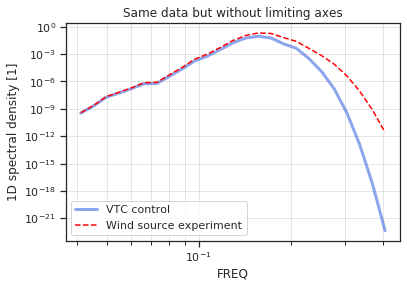

In [317]:
with sns.axes_style('ticks'):
    plt.grid(True,which='both',alpha=0.5)
    print(control_ww.sel(NY=latslice).HS[temp['NY'],temp['NX']],
          wind_exp_ww.sel(NY=latslice).HS[temp['NY'],temp['NX']])
    print(control_ww.sel(NY=latslice).ICE[temp['NY'],temp['NX']],
          wind_exp_ww.sel(NY=latslice).ICE[temp['NY'],temp['NX']])
    print(cwind[temp['NY'],temp['NX']])
    control_ww.sel(NY=latslice).EF[:,temp['NY'],temp['NX']].plot(c='royalblue',alpha=0.6,lw=3,label='VTC control')
    wind_exp_ww.sel(NY=latslice).EF[:,temp['NY'],temp['NX']].plot(c='r',ls='--',label='Wind source experiment')
    plt.loglog()
    # plt.xlim(0.06,0.5)
    # plt.ylim(.01,10)
    plt.xlim(10**(-1.24),10**(-0.3))
    plt.ylim(10**(-4),5*10**(1))
#     plt.title('Maximum H$_s$ on 2012-08-10: '+ str(np.round(wind_exp_ww_sub.HS[55,212].values,2)) + ' [m]')
    plt.legend()
    plt.show()
    
    plt.grid(True,which='both',alpha=0.5)
    control_ww.sel(NY=latslice).EF[:,temp['NY'],temp['NX']].plot(c='royalblue',alpha=0.6,lw=3,label='VTC control')
    wind_exp_ww.sel(NY=latslice).EF[:,temp['NY'],temp['NX']].plot(c='r',ls='--',label='Wind source experiment')
    plt.loglog()
    # plt.xlim(0.06,0.5)
    # plt.ylim(.01,10)
#     plt.xlim(10**(-1.24),10**(-0.3))
#     plt.ylim(10**(-4),5*10**(1))
    plt.title('Same data but without limiting axes')
    plt.legend()
    plt.show()

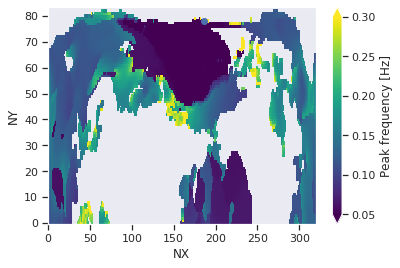

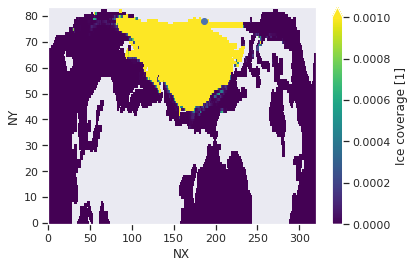

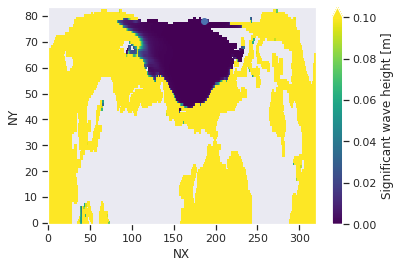

In [218]:
wind_exp_ww.FP0.sel(NY=latslice).plot(vmin=0.05,vmax=0.3)
plt.scatter(186,378-300)
plt.show()

wind_exp_ww.ICE.sel(NY=latslice).plot(vmin=0,vmax=0.001)
plt.scatter(186,378-300)
plt.show()

wind_exp_ww.HS.sel(NY=latslice).plot(vmin=0,vmax=0.1)
plt.scatter(186,378-300)
plt.show()